## Tutorial for FootballCPD
Section 4 (except 4.1.3) in the paper

In [21]:
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from scipy.spatial import Delaunay
import rpy2.robjects.packages as rpackages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

from src.myconstants import *
from src.recordmanager import RecordManager
from src.match import Match
from src.footballcpd import FootballCPD

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)

### Execution of FootballCPD using preprocessed GPS data

In [23]:
# Choose an activity to analyze
activity_id = 245
rm = RecordManager()
activity_record, player_periods, roster, ugp_df = rm.load_activity_data(activity_id)
activity_record

activity_id              245
team_id                    1
type                official
date                20200101
team_name          anonymous
home_away                  H
rotated_session            1
data_saved                 1
stats_saved                0
Name: 0, dtype: object

In [24]:
# GPS data after basic preprocessing
# (called "UGP data" as an abbreviation of "upgraded GPS data")
ugp_df

player_id  player_period  session  gametime      unixtime  duration       x       y     speed
2019-12-31 23:26:49.100     1365.0            NaN      NaN       NaN  1.577835e+09       0.1  3362.0  8191.0  0.233274
2019-12-31 23:26:49.200     1365.0            NaN      NaN       NaN  1.577835e+09       0.1  3366.0  8185.0  0.318801
2019-12-31 23:26:49.300     1365.0            NaN      NaN       NaN  1.577835e+09       0.1  3366.0  8181.0  0.369413
2019-12-31 23:26:49.400     1365.0            NaN      NaN       NaN  1.577835e+09       0.1  3364.0  8178.0  0.391145
2019-12-31 23:26:49.500     1365.0            NaN      NaN       NaN  1.577835e+09       0.1  3360.0  8177.0  0.390031
...                            ...            ...      ...       ...           ...       ...     ...     ...       ...
2020-01-01 01:58:59.600     5608.0            NaN      NaN       NaN  1.577844e+09       0.1  4381.0  4760.0  5.710166
2020-01-01 01:58:59.700     5608.0            NaN      NaN       NaN  1.577844e+09       0.1  4370.0  4750.0  5.709115
2020-01-01 01:58:59.800     5608.0            NaN      NaN       NaN  1.577844e+09       0.1  4358.0  4740.0  5.708764
2020-01-01 01:58:59.900     5608.0            NaN      NaN       NaN  1.577844e+09       0.1  4347.0  4728.0  5.709465
2020-01-01 01:59:00.000     5608.0            NaN      NaN       NaN  1.577844e+09       0.1  4336.0  4716.0  5.711568

[635855 rows x 9 columns]

In [25]:
# Further processing of UGP data using the official match log
match = Match(activity_record, player_periods, roster, ugp_df)

# (1) Filter in-play data from the measured data using the start, end, and substitution records
match.construct_inplay_df()

# (2) Rotate the pitch for one of the sessions so that the team always attacks from left to right
match.rotate_pitch()

match.ugp_df

player_id player_period session gametime      unixtime  duration       x       y     speed
2020-01-01 00:00:00.100      4181             1       1  00:00.1  1.577837e+09       0.1  4633.0   574.0  4.615196
2020-01-01 00:00:00.200      4181             1       1  00:00.2  1.577837e+09       0.1  4642.0   561.0  4.655973
2020-01-01 00:00:00.300      4181             1       1  00:00.3  1.577837e+09       0.1  4651.0   548.0  4.714858
2020-01-01 00:00:00.400      4181             1       1  00:00.4  1.577837e+09       0.1  4659.0   534.0  4.781228
2020-01-01 00:00:00.500      4181             1       1  00:00.5  1.577837e+09       0.1  4667.0   519.0  4.844462
...                           ...           ...     ...      ...           ...       ...     ...     ...       ...
2020-01-01 01:48:59.600      5527             4       2  47:59.6  1.577843e+09       0.1  1121.0  2817.0  1.856839
2020-01-01 01:48:59.700      5527             4       2  47:59.7  1.577843e+09       0.1  1128.0  2820.0  2.125829
2020-01-01 01:48:59.800      5527             4       2  47:59.8  1.577843e+09       0.1  1135.0  2824.0  2.457998
2020-01-01 01:48:59.900      5527             4       2  47:59.9  1.577843e+09       0.1  1142.0  2828.0  2.809422
2020-01-01 01:49:00.000      5527             4       2  48:00.0  1.577843e+09       0.1  1150.0  2832.0  3.136177

[733200 rows x 9 columns]

In [5]:
# Install and import the R package 'gSeg' to be used in FootballCPD
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
if not rpackages.isinstalled('gSeg'):
    utils.install_packages('gSeg')
rpackages.importr('gSeg')

# Apply FootballCPD on the preprocessed match data
cpd = FootballCPD(match, gseg_type='avg')
cpd.run()
cpd.visualize()
cpd.save_stats()


---------------------------- Session 1 -----------------------------
                 type session gametime   start_dt              end_dt
player_period                                                        
1              START1       1    00~46 2020-01-01 2020-01-01 00:46:00

* Step 1: Frame-by-frame role assignment using RoleRep
- Cost after iteration 1: 15.533
- Cost after iteration 2: 15.355
- Cost after iteration 3: 15.344
- Cost after iteration 4: 15.340
Iteration finished since there are no significant changes.

* Step 2: FormCPD based on role-adjacency matrices
Running 'gSeg' to detect a change-point between 00:00:01 and 00:46:00...
Generalized edge-count statistic (a) : 
  Estimated change-point location: 1040 
  Test statistic: 1940.918 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 987 
  Test statistic: 9364.465 
  Approximated p-value: 0 
A significant fine-tuned change-point at 00:18:13

Running 'gSeg' to detect a

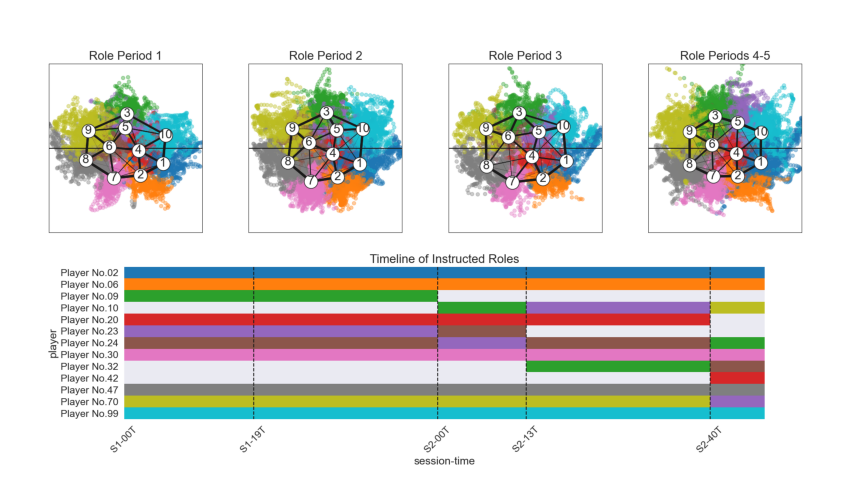

In [17]:
report_path = f'{DIR_DATA}/report_{cpd.gseg_type}/{activity_id}.png'
img = mpimg.imread(report_path)
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(img)
plt.show()

### Visualizing temporary Delaunay graphs
Fig. 2(a) in the paper

In [26]:
# FGP data (an abbreviation of "GPS data resulting from FootballCPD")
activity_id = 245
fgp_path = f'{DIR_DATA}/fgp_avg/{activity_id}.csv'
fgp_df = pd.read_csv(fgp_path, sep=',', header=0)
fgp_df

player_id  squad_num player_name             datetime  session gametime  player_period  form_period  role_period       x       y  x_norm  y_norm  role  base_role  switch_rate
0           4181          2         P02  2020-01-01 00:00:01        1  00:01.0              1            1            1  4667.0   512.0   -58.0 -2862.6     1          1          0.2
1           4181          2         P02  2020-01-01 00:00:02        1  00:02.0              1            1            1  4694.0   388.0   -37.5 -2982.2     1          1          0.2
2           4181          2         P02  2020-01-01 00:00:03        1  00:03.0              1            1            1  4657.0   315.0  -112.2 -3034.6     1          1          0.0
3           4181          2         P02  2020-01-01 00:00:04        1  00:04.0              1            1            1  4681.0   340.0  -155.1 -3033.7     1          1          0.0
4           4181          2         P02  2020-01-01 00:00:05        1  00:05.0              1            1            1  4718.0   440.0  -185.7 -3017.1     1          1          0.0
...          ...        ...         ...                  ...      ...      ...            ...          ...          ...     ...     ...     ...     ...   ...        ...          ...
56352       4142         99         P99  2020-01-01 01:48:56        2  47:56.0              4            4            5  2624.0  1881.0  1072.1 -1456.9    10         10          0.5
56353       4142         99         P99  2020-01-01 01:48:57        2  47:57.0              4            4            5  2438.0  1801.0  1010.5 -1469.9    10         10          0.5
56354       4142         99         P99  2020-01-01 01:48:58        2  47:58.0              4            4            5  2269.0  1820.0   884.9 -1349.0    10         10          0.5
56355       4142         99         P99  2020-01-01 01:48:59        2  47:59.0              4            4            5  2171.0  1959.0   781.4 -1169.7    10         10          0.5
56356       4142         99         P99  2020-01-01 01:49:00        2  48:00.0              4            4            5  2164.0  2087.0   730.1 -1046.7    10         10          0.4

[56357 rows x 16 columns]

In [7]:
player_x = fgp_df.pivot_table(values='x', index='datetime', columns='player_name', aggfunc='first')
player_y = fgp_df.pivot_table(values='y', index='datetime', columns='player_name', aggfunc='first')
role_x = fgp_df.pivot_table(values='x', index='datetime', columns='role', aggfunc='first')
role_y = fgp_df.pivot_table(values='y', index='datetime', columns='role', aggfunc='first')
perms = fgp_df.pivot_table(values='role', index='datetime', columns='player_name', aggfunc='first')
perms

player_name          P02  P06  P09  P10  P20  P23  P24  P30  P32  P42  P47  P70   P99
datetime                                                                             
2020-01-01 00:00:01  1.0  2.0  5.0  NaN  4.0  3.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 00:00:02  1.0  2.0  5.0  NaN  4.0  3.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 00:00:03  1.0  2.0  3.0  NaN  4.0  5.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 00:00:04  1.0  2.0  3.0  NaN  4.0  5.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
2020-01-01 00:00:05  1.0  2.0  3.0  NaN  4.0  5.0  6.0  7.0  NaN  NaN  8.0  9.0  10.0
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...
2020-01-01 01:48:56  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 01:48:57  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 01:48:58  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 01:48:59  1.0  4.0  NaN  3.0  NaN  NaN  6.0  7.0  9.0  2.0  8.0  5.0  10.0
2020-01-01 01:49:00  1.0  3.0  NaN  6.0  NaN  NaN  2.0  7.0  9.0  4.0  8.0  5.0  10.0

[5640 rows x 13 columns]

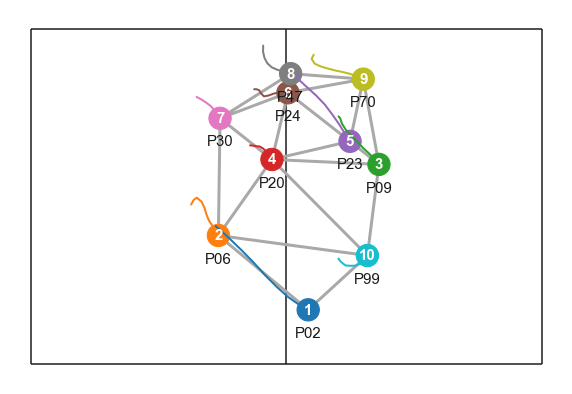

In [31]:
# Set the starting index of the animation
idx = 400
fontsize = 15

players = player_x.columns
roles = np.sort(fgp_df['role'].unique())
colors = plt.cm.tab10(range(10))

xlim = 10800
ylim = 7200

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set(xlim=(-500, xlim + 500), ylim=(-500, ylim + 500))
objs = []

def animate(t):
    ax.clear()
    ax.set(xlim=(-500, xlim + 500), ylim=(-500, ylim + 500))
    ax.vlines([0, xlim/2, xlim], ymin=0, ymax=ylim, color='k', zorder=0)
    ax.hlines([0, ylim], xmin=0, xmax=xlim, color='k', zorder=0)
    ax.axis('off')
    
    tri = Delaunay(np.vstack((role_x.iloc[idx+t], role_y.iloc[idx+t])).T)
    ax.scatter(tri.points[:, 0], tri.points[:, 1], s=500, c=roles, cmap='tab10', zorder=1)
    ax.triplot(tri.points[:, 0], tri.points[:, 1], tri.simplices,
               color='darkgrey', linewidth=3, zorder=0)
    
    for p in players:
        temp_x = player_x[p][max(0,idx+t-9):idx+t+1].values
        temp_y = player_y[p][max(0,idx+t-9):idx+t+1].values
        r = perms[p].iloc[idx+t]
        if not np.isnan(r):
            r = int(r)
            ax.plot(temp_x, temp_y, color=colors[r-1], linewidth=2)
            ax.annotate(r, xy=(role_x[r].iloc[idx+t], role_y[r].iloc[idx+t]),
                        ha='center', va='center', color='w', fontsize=fontsize, fontweight='bold', zorder=2)
            ax.annotate(p, xy=(role_x[r].iloc[idx+t], role_y[r].iloc[idx+t]-500), 
                        ha='center', va='center', color='k', fontsize=fontsize, zorder=2)

# To watch the snapshot, uncomment this code
animate(0)

# To watch the animation, uncomment this code
# anim = animation.FuncAnimation(fig, animate, frames=100, interval=250)
# plt.close(fig)
# HTML(anim.to_jshtml())

# To save the animation, uncomment this code
# anim.save('img/delaunay.gif', writer='pillow', fps=4)

### Visualizing the "mean" Delaunay graph
Fig. 2(b) in the paper

In [10]:
def delaunay_edge_mat(coords):
    tri_pts = Delaunay(coords).simplices
    edges = np.concatenate((tri_pts[:, :2], tri_pts[:, 1:], tri_pts[:, ::2]), axis=0)
    edge_mat = np.zeros((coords.shape[0], coords.shape[0]))
    edge_mat[edges[:, 0], edges[:, 1]] = 1
    return np.clip(edge_mat + edge_mat.T, 0, 1)

In [12]:
# Choose an activity and a formation period
activity_id = 245
form_period = 1

fgp_path = f'{DIR_DATA}/fgp_avg/{activity_id}.csv'
fgp_df = pd.read_csv(fgp_path, sep=',', header=0)

period_fgp_df = fgp_df[fgp_df['form_period'] == form_period]
period_role_x = period_fgp_df.pivot_table(values='x_norm', index='datetime', columns='role', aggfunc='first')
period_role_y = period_fgp_df.pivot_table(values='y_norm', index='datetime', columns='role', aggfunc='first')
period_role_coords = np.dstack([period_role_x.dropna().values, period_role_y.dropna().values])

period_edge_mats = []
for coords in period_role_coords:
    period_edge_mats.append(delaunay_edge_mat(coords))
period_edge_mats = np.stack(period_edge_mats, axis=0)

mean_role_coords = period_role_coords.mean(axis=0)
mean_edge_mat = period_edge_mats.mean(axis=0)

period_edge_mats, mean_edge_mat

(array([[[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.]],
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 1., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 1.],
         [0., 0., 1., ..., 1., 0., 0.],


In [13]:
def visualize_formation(coords, edge_mat):
    plt.figure(figsize=(10, 7))
    plt.scatter(coords[:, 0], coords[:, 1], c=np.arange(10)+1,
                s=700, vmin=0.5, vmax=10.5, cmap='tab10', zorder=1)

    for i in np.arange(10):
        plt.annotate(i + 1, xy=coords[i], ha='center', va='center',
                     c='w', fontsize=20, fontweight='bold', zorder=2)
        for j in np.arange(10):
            plt.plot(coords[[i, j], 0], coords[[i, j], 1],
                     linewidth=edge_mat[i, j] ** 2 * 10, c='k', zorder=0)

    xlim = 3000
    ylim = 2400
    plt.xlim(-xlim - 500, xlim + 500)
    plt.ylim(-ylim - 500, ylim + 500)
    plt.vlines([-xlim, 0, xlim], ymin=-ylim, ymax=ylim, color='k', zorder=0)
    plt.hlines([-ylim, ylim], xmin=-xlim, xmax=xlim, color='k', zorder=0)
    plt.axis('off')

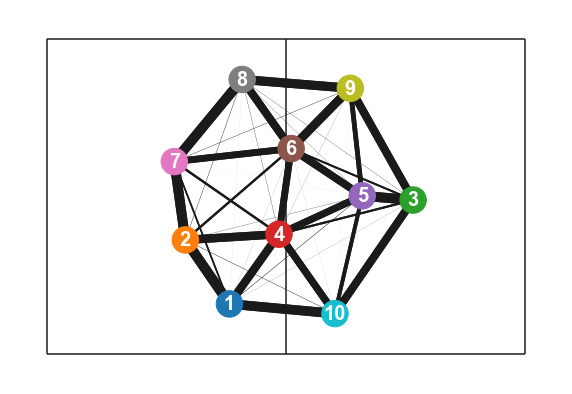

In [14]:
visualize_formation(mean_role_coords, mean_edge_mat)

### Model Evaluation

In [25]:
header = ['activity_id', 'session', 'phase', 'form_period', 'role_period', 'start_time']
role_records = fgp_df.groupby('role_period', as_index=False).first()[header[1:-1] + ['lapse']]
role_records['activity_id'] = activity_id
role_records['start_time'] = role_records['lapse'].apply(lambda x: int(x[:2]))
role_records[header]

activity_id  session  phase  form_period  role_period  start_time
0        17985        1      1            1            1           0
1        17985        1      1            2            2          17
2        17985        2      2            3            3           0
3        17985        2      3            4            4          13
4        17985        2      4            4            5          40

In [28]:
forms_true = pd.read_csv('data/form_tags_true.csv', header=0).astype(int)
forms_pred = pd.read_csv('data/form_tags_pred.csv', header=0)
activity_ids = forms_true['activity_id'].unique()
forms_true

activity_id  session  start_time  end_time  formation
0           2310        1           0        20       4231
1           2310        1          20        46       4231
2           2310        2           0        22       4231
3           2310        2          22        42       4231
4           2310        2          42        51        433
..           ...      ...         ...       ...        ...
144        21689        2          39        50        352
145        21704        1           0        47        433
146        21704        2           0         5        433
147        21704        2           5        11        433
148        21704        2          11        50        433

[149 rows x 5 columns]

In [30]:
activity_ids = forms_true['activity_id'].unique()
header = ['activity_id', 'session', 'phase', 'form_period', 'role_period',
          'start_time', 'end_time', 'duration']

In [41]:
fgp_files_2019 = os.listdir('data/2019_kleague/fgp_avg')
fgp_files_2020 = os.listdir('data/2020_kleague/fgp_avg')

role_period_list = []
for file in tqdm(fgp_files_2019):
    activity_id = int(file.split('.')[0])
    if activity_id not in activity_ids:
        continue
    path = f'data/2019_kleague/fgp_avg/{file}'
    fgp_df = pd.read_csv(path, header=0, encoding='utf-8-sig')
    # count += len(fgp_df['role_period'].unique())
    grouped = fgp_df.groupby('role_period', as_index=False)
    match_role_periods = grouped.first()[header[1:5] + ['lapse']]
    match_role_periods['activity_id'] = activity_id
    match_role_periods['start_time'] = match_role_periods['lapse'].apply(lambda x: int(x[:2]))
    match_role_periods['end_time'] = grouped['lapse'].last().apply(lambda x: int(x[:2]))
    start_dt = grouped
    role_period_list.append(match_role_periods[header[:-1]])

for file in tqdm(fgp_files_2020):
    activity_id = int(file.split('.')[0])
    if activity_id not in activity_ids:
        continue
    path = f'data/2020_kleague/fgp_avg/{file}'
    fgp_df = pd.read_csv(path, header=0, encoding='utf-8-sig')
    # count += len(fgp_df['role_period'].unique())
    grouped = fgp_df.groupby('role_period', as_index=False)
    match_role_periods = grouped.first()[header[1:5] + ['lapse']]
    match_role_periods['activity_id'] = activity_id
    match_role_periods['start_time'] = match_role_periods['lapse'].apply(lambda x: int(x[:2]))
    match_role_periods['end_time'] = grouped['lapse'].last().apply(lambda x: int(x[:2]))
    start_dt = grouped
    role_period_list.append(match_role_periods[header[:-1]])
    
role_periods = pd.concat(role_period_list, axis=0, ignore_index=True).astype(int)
role_periods

  5%|███▉                                                                             | 10/207 [00:00<00:03, 58.29it/s]


TypeError: cannot convert the series to <class 'int'>

In [42]:
role_periods = pd.read_csv('data/role_periods.csv', header=0)
role_periods

activity_id  session  phase  form_period  role_period  start_time
0           2310        1      1            1            1           0
1           2310        1      1            1            2          35
2           2310        2      2            2            3           0
3           2310        2      3            2            4          22
4           2310        2      4            2            5          42
..           ...      ...    ...          ...          ...         ...
148        21704        1      1            1            3          23
149        21704        1      1            1            4          31
150        21704        2      2            2            5           0
151        21704        2      2            2            6           6
152        21704        2      3            2            7          11

[153 rows x 6 columns]

In [44]:
cols = ['activity_id', 'form_period', 'session', 'start_time']
form_periods = role_periods.groupby(cols[:2], as_index=False).first()[cols]
forms_pred = pd.merge(form_periods, form_records)

In [57]:
forms_pred = pd.merge(role_periods, form_records[['activity_id', 'session', 'form_period', 'form']])
forms_pred.to_csv('data/form_tags_pred.csv', index=False, encoding='utf-8-sig')

In [37]:
role_period_df.to_csv('data/role_periods.csv', index=False, encoding='utf-8-sig')

In [288]:
session_ids = form_records.apply(lambda x: f"{x['activity_id']}-{x['session']}", axis=1)
session_ids.unique().shape

(809,)

In [120]:
forms_true = pd.read_csv('data/form_tags_true.csv', header=0)
forms_pred = pd.read_csv('data/form_tags_pred.csv', header=0)
forms_pred

activity_id  session  phase  form_period  role_period  start_time  end_time formation
0           2310        1      1            1            1           0        35       442
1           2310        1      1            1            2          35        46       442
2           2310        2      2            2            3           0        22       343
3           2310        2      3            2            4          22        42       343
4           2310        2      4            2            5          42        51       343
..           ...      ...    ...          ...          ...         ...       ...       ...
147        21704        1      1            1            3          23        31      4231
148        21704        1      1            1            4          31        47      4231
149        21704        2      2            2            5           0         6       442
150        21704        2      2            2            6           6        11       442
151        21704        2      3            2            7          11        50       442

[152 rows x 8 columns]

In [70]:
forms_pred['end_time'] = forms_pred['start_time'].shift(-1)
forms_pred.iat[-1, -1] = 0
forms_pred.loc[forms_pred['end_time'] == 0, 'end_time'] = forms_true.groupby(['activity_id', 'session'])['end_time'].last().values
forms_pred['end_time'] = forms_pred['end_time'].astype(int)
forms_pred.iloc[:10]

activity_id  session  phase  form_period  role_period  start_time form  end_time
0         2310        1      1            1            1           0  442        35
1         2310        1      1            1            2          35  442        46
2         2310        2      2            2            3           0  343        22
3         2310        2      3            2            4          22  343        42
4         2310        2      4            2            5          42  343        51
5         3447        1      1            1            1           0  352        32
6         3447        1      2            1            2          32  352        47
7         3447        2      3            2            3           0  352        36
8         3447        2      4            2            4          36  352        50
9         4898        1      1            1            1           0  442        37

In [71]:
forms_true.to_csv('data/form_tags_true.csv', index=False)
forms_pred.to_csv('data/form_tags_pred.csv', index=False)

In [121]:
mins_header = ['activity_id', 'session', 'start_time', 'formation']
mins_true = []
for i in forms_true.index:
    period_true = forms_true.iloc[i]
    start_time = period_true['start_time']
    end_time = period_true['end_time']
    duration = end_time - start_time
    period_mins_true = pd.DataFrame(
        np.repeat(period_true[mins_header].values[np.newaxis], duration, axis=0), columns=mins_header
    )
    period_mins_true['start_time'] = np.arange(start_time, end_time)
    mins_true.append(period_mins_true)
mins_true = pd.concat(mins_true, axis=0, ignore_index=True)
mins_true['formation'] = mins_true['formation'].astype(str)
mins_true

activity_id session  start_time formation
0           2310       1           0       442
1           2310       1           1       442
2           2310       1           2       442
3           2310       1           3       442
4           2310       1           4       442
...          ...     ...         ...       ...
2675       21704       2          45       442
2676       21704       2          46       442
2677       21704       2          47       442
2678       21704       2          48       442
2679       21704       2          49       442

[2680 rows x 4 columns]

In [122]:
mins_pred = []
for i in forms_pred.index:
    period_pred = forms_pred.iloc[i]
    start_time = period_pred['start_time']
    end_time = period_pred['end_time']
    duration = end_time - start_time
    period_mins_pred = pd.DataFrame(
        np.repeat(period_pred[mins_header].values[np.newaxis], duration, axis=0), columns=mins_header
    )
    period_mins_pred['start_time'] = np.arange(start_time, end_time)
    mins_pred.append(period_mins_pred)
mins_pred = pd.concat(mins_pred, axis=0, ignore_index=True)
mins_pred

activity_id session  start_time formation
0           2310       1           0       442
1           2310       1           1       442
2           2310       1           2       442
3           2310       1           3       442
4           2310       1           4       442
...          ...     ...         ...       ...
2675       21704       2          45       442
2676       21704       2          46       442
2677       21704       2          47       442
2678       21704       2          48       442
2679       21704       2          49       442

[2680 rows x 4 columns]

In [123]:
pd.merge(mins_true, mins_pred)

activity_id session  start_time formation
0           2310       1           0       442
1           2310       1           1       442
2           2310       1           2       442
3           2310       1           3       442
4           2310       1           4       442
...          ...     ...         ...       ...
2042       21704       2          45       442
2043       21704       2          46       442
2044       21704       2          47       442
2045       21704       2          48       442
2046       21704       2          49       442

[2047 rows x 4 columns]

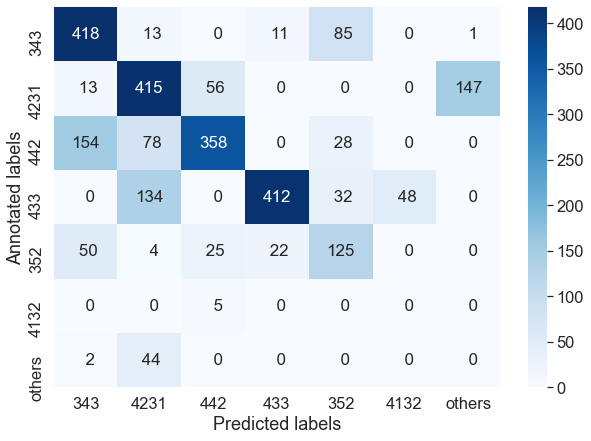

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

formations = ['343', '4231', '442', '433', '352', '4132', 'others']
conf_mat = confusion_matrix(
    mins_true['formation'].values, mins_pred['formation'].values, labels=formations
)
conf_mat = pd.DataFrame(conf_mat, index=formations, columns=formations)

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.5)
sn.heatmap(conf_mat, cmap='Blues', annot=True, fmt='3d', annot_kws={"size": 15, })
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig('form_conf.pdf',bbox_inches='tight')

In [8]:
activity_id = 17985
fgp_path = f'data/2020_kleague/fgp_avg/{activity_id}.csv'
fgp_df = pd.read_csv(fgp_path, sep=',', header=0)
fgp_df

player_id  squad_num position  player_name             datetime  session    lapse  phase  form_period  role_period       x       y  x_norm  y_norm  role  base_role  switch_rate
0           4181          2       DF  Dahwon Jung  2020-09-05 19:00:01        1  00:01.0      1            1            1  4809.0  1206.0   -58.0 -2862.6     1          1          0.2
1           4181          2       DF  Dahwon Jung  2020-09-05 19:00:02        1  00:02.0      1            1            1  4836.0  1082.0   -37.5 -2982.2     1          1          0.0
2           4181          2       DF  Dahwon Jung  2020-09-05 19:00:03        1  00:03.0      1            1            1  4799.0  1009.0  -112.2 -3034.6     1          1          0.0
3           4181          2       DF  Dahwon Jung  2020-09-05 19:00:04        1  00:04.0      1            1            1  4823.0  1034.0  -155.1 -3033.7     1          1          0.0
4           4181          2       DF  Dahwon Jung  2020-09-05 19:00:05        1  00:05.0      1            1            1  4860.0  1134.0  -185.7 -3017.1     1          1          0.0
...          ...        ...      ...          ...                  ...      ...      ...    ...          ...          ...     ...     ...     ...     ...   ...        ...          ...
56352       4142         99       FW   Jaegun Lee  2020-09-05 20:48:56        2  47:56.0      4            4            5  2624.0  1881.0  1072.1 -1456.9    10         10          0.5
56353       4142         99       FW   Jaegun Lee  2020-09-05 20:48:57        2  47:57.0      4            4            5  2438.0  1801.0  1010.5 -1469.9    10         10          0.5
56354       4142         99       FW   Jaegun Lee  2020-09-05 20:48:58        2  47:58.0      4            4            5  2269.0  1820.0   884.9 -1349.0    10         10          0.5
56355       4142         99       FW   Jaegun Lee  2020-09-05 20:48:59        2  47:59.0      4            4            5  2171.0  1959.0   781.4 -1169.7    10         10          0.5
56356       4142         99       FW   Jaegun Lee  2020-09-05 20:49:00        2  48:00.0      4            4            5  2164.0  2087.0   730.1 -1046.7    10         10          0.4

[56357 rows x 17 columns]

In [9]:
role_records = pd.read_pickle(os.path.join(SUBDIR_DATA, 'role_records.pkl'))
match_role_records = role_records[role_records['activity_id'] == activity_id]

In [10]:
role_locs = match_role_records[['session', 'role', 'x', 'y']]
role_locs = pd.merge(
    fgp_df[['datetime', 'session', 'player_id', 'base_role', 'x_norm', 'y_norm']],
    role_locs.rename(columns={'role': 'base_role', 'x': 'base_x', 'y': 'base_y'})
)
deform_x = role_locs['x_norm'] - role_locs['base_x']
deform_y = role_locs['y_norm'] - role_locs['base_y']
role_locs['deform'] = pd.concat([deform_x, deform_y], axis=1).apply(np.linalg.norm, axis=1)
role_locs

datetime session  player_id base_role  x_norm  y_norm      base_x       base_y       deform
0      2020-09-05 19:00:01       1       4181         1   -58.0 -2862.6 -730.571163 -1700.066558  1343.069608
1      2020-09-05 19:00:02       1       4181         1   -37.5 -2982.2 -730.571163 -1700.066558  1457.468284
2      2020-09-05 19:00:03       1       4181         1  -112.2 -3034.6 -730.571163 -1700.066558  1470.837313
3      2020-09-05 19:00:04       1       4181         1  -155.1 -3033.7 -730.571163 -1700.066558  1452.496202
4      2020-09-05 19:00:05       1       4181         1  -185.7 -3017.1 -730.571163 -1700.066558  1425.293539
...                    ...     ...        ...       ...     ...     ...         ...          ...          ...
56352  2020-09-05 20:48:56       2       4142        10  1072.1 -1456.9  840.281120 -1702.564448   337.773614
56353  2020-09-05 20:48:57       2       4142        10  1010.5 -1469.9  840.281120 -1702.564448   288.283216
56354  2020-09-05 20:48:58       2       4142        10   884.9 -1349.0  840.281120 -1702.564448   356.368719
56355  2020-09-05 20:48:59       2       4142        10   781.4 -1169.7  840.281120 -1702.564448   536.107738
56356  2020-09-05 20:49:00       2       4142        10   730.1 -1046.7  840.281120 -1702.564448   665.054925

[56357 rows x 9 columns]

In [11]:
x_norm = role_locs.pivot_table(values='x_norm', index='datetime', columns='base_role', aggfunc='first')
y_norm = role_locs.pivot_table(values='y_norm', index='datetime', columns='base_role', aggfunc='first')

In [12]:
player_ids = fgp_df['player_id'].unique()
roles = np.sort(fgp_df['role'].unique())
colors = plt.cm.tab10(range(10))

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set(xlim=(-5000, 5000), ylim=(-3500, 3500))

session = role_locs.at[0, 'session']
base_x = match_role_records.loc[match_role_records['session'] == session, 'x']
base_y = match_role_records.loc[match_role_records['session'] == session, 'y']

temp_scat = ax.scatter(x_norm.iloc[0], y_norm.iloc[0], s=200, c=roles, cmap='tab10')
base_scat = ax.scatter(base_x, base_y, s=300, c=roles, cmap='tab10', marker='s')
lines = dict()
anots = dict()
for r in roles:
    lines[r], = ax.plot([x_norm[r].iloc[0], base_x.iloc[r-1]],
                        [y_norm[r].iloc[0], base_y.iloc[r-1]], color=colors[r-1])
    anots[r] = ax.annotate(r, xy=(base_x.iloc[r-1], base_y.iloc[r-1]), ha='center', va='center',
                           color='w', fontsize=12, fontweight='bold')
    anots[r].set_animated(True)
    
def animate(i):
    t = i + 200
    global session, base_x, base_y
    temp_session = role_locs.at[t, 'session']
    if temp_session != session:
        session = temp_session
        base_x = match_role_records.loc[match_role_records['session'] == session, 'x']
        base_y = match_role_records.loc[match_role_records['session'] == session, 'y']
        base_scat.set_offsets(pd.concat([base_x, base_y], axis=1).values)
        for r in roles:
            anots[r].set_position((base_x.iloc[r-1], base_y.iloc[r-1]))
    
    temp_scat.set_offsets(np.array([x_norm.iloc[t], y_norm.iloc[t]]).T)
    for r in roles:
        lines[r].set_data([x_norm[r].iloc[t], base_x.iloc[r-1]],
                          [y_norm[r].iloc[t], base_y.iloc[r-1]])   

ani = animation.FuncAnimation(fig, animate, frames=200, interval=250)
plt.close(fig)
HTML(ani.to_jshtml())

In [83]:
ani.save('formationtools/deform.gif', writer='pillow', fps=4)